# Advertisement in russian-speaking Instagram - PART II

Fisrt part of the project was dedicated to exploratory analysis of the database with advertisemnt reviews written by bloggers-clients. Based on the provided analysis I tried to choose ad placement according to my goal and budget.

Even though we can vaguely calculate how many subscribers will come after advertisement, it would be very handy, if we could predict this number using machine learning.

So, the goal of the second part of this project is to create a model and a function that can predict resulting amount of new subscribers with some level of certainity.

*This time I will comment on every step with technical information that supports my decisions.*

## 2.1 PREPARING  DATASET# 1. Import and cleaning dataset¶

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from scipy import stats
from sklearn.linear_model import Ridge

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import Lasso
import math
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier


In [2]:
file = 'https://raw.githubusercontent.com/ElinaAizenberg/Advertisement-in-Russian-speaking-Instagram---project/main/data/easyprbot.com_reviews_2021_03_05.csv'
table = pd.read_csv(file, header = 0, sep = ';')

As I split the project and performed analysis/modelling separetely, I have to repeate several pre-processing steps. Although, I repeate description of these steps for those readers who skip the first part of the project.

In [3]:
table.head()

,ID,Дата рекламы,Мой аккаунт,Брали рекламу у блогера,Цена за подписчика,Приход,Цена за рекламу,Охваты из рекламы,Оценка,Формат рекламы,Темы аккаунта,Текст отзыва
0,59,2019-07-02,masha_davay,chebotareva_e,2.0,4000,10000.0,NaN,10,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...",Реклама была супер. Весь день в сторис у Элины...
1,61,2019-07-02,since1545,easy__history,0.0,266,200.0,NaN,10,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...",Она очень ответственно подошла к рекламе из вс...
2,63,2019-07-02,gassanchiki,_anarykova_,7.0,800,6000.0,NaN,5,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...","Вроде всё неплохо, но\nЗаявленный охват 30-50\..."
3,64,2019-07-02,irene.english.live,vika_portland_film,6.0,300,2000.0,NaN,8,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...","Вика очень приятная в общении, идет на встречу..."
4,65,2019-07-01,p,markelova.love,1.0,200,300.0,NaN,10,Сторис,"Жизнь заграницей, Лайфстайл, Мода, стиль и шоп...",Шикарный подход к подаче рекламы: блогер вылож...


**First steps:**

1. delete columns ID, client's account name, Comment;
2. delete rows where price for ad was 0 RUB, because these were 'mutual PR' cases that are useless for my goal;
3. delete rows where format of advertisment was 'Giveaway' because it's quite specific case;
4. as far as I know results of advertisement might depend on week day and month, therefore I create columns with this information based on Date column;
5. drop rows with absent information about prices for ad and ad's statistics because this information is of paramount importance for analysis;
6. re-calculate column Price for subscriber because it's manually filled in by reviewers with serious errors;
7. translate column names to English.


In [4]:
cols = [0,2,11]

# inplace=True is used to make the changes in the dataframe itself without doing the column dropping on a copy of the data frame.
table.drop(table.columns[cols],axis=1,inplace=True)

# where price for the ad is 0, it means 'mutual PR'. It is also useless for my goal.
table = table[table['Цена за рекламу'] != 0]

#Giveaway is not perconal ad, therefore, not suitable for my model
table = table[table['Формат рекламы'] != 'Гив']

#as far as I know results of an ad depend on week day and month
table['Дата рекламы'] = pd.to_datetime(table['Дата рекламы'], format = '%Y-%m-%d')
table['Month'] = table['Дата рекламы'].dt.month
table['Week day'] = table['Дата рекламы'].dt.weekday

table = table.dropna(subset = ['Цена за рекламу','Охваты из рекламы'])

# The price per subscriber column is terribly calculated (manually by respondents), so, I replace it
# When amount of coming subscribers equals to 0, then the price per subsriber is infinite. To eliminate it, I change the price with the total sum for ad.
table['Цена за подписчика'] = table.apply(lambda row: np.round(row['Цена за рекламу'] / row['Приход'], 2) if row['Приход'] != 0 else row['Цена за рекламу'], axis = 1) 

table = table.reset_index(drop = True)

table = table.rename(columns={'Дата рекламы':'Date', 'Брали рекламу у блогера':'Blogger', 'Цена за подписчика':'Price per subscriber',
       'Приход':'Income', 'Цена за рекламу':'Price per ad', 'Охваты из рекламы':'Ad coverage', 'Оценка':'Rate',
       'Формат рекламы':'Format', 'Темы аккаунта':"Account's topic"}, errors="raise")

In [5]:
print('Current shape of the dataframe is {} rows and {} columns.'.format(table.shape[0], table.shape[1]))

Current shape of the dataframe is 24303 rows and 11 columns.


**Get dummy variables**

A reviewer can list unlimited amount of topics in column Account's topic. I transform this column into multiple dummy variables with 1 or 0 values whether a particular topic was mentioned or not.

Columns Format, Month and Week day are categorical variables. In order to include these variables in a regression model I need to transform them into a set of binary variables.

**Dummy Variable Trap**

Dummy Variable Trap is a situation when independent variables are multicollinear and it is caused by including dummy variables that represent all possible categories of original variable. As a result it will have negative impact on regression algorithm. Even though multicollinearity doesn't affect predictive accuracy of a regression model, it undermines the statistical significance of the independent variables. To avoid this, one of the options in a categorical value should be droped.


In [6]:
table = pd.concat([table,table["Account's topic"].str.get_dummies(sep=', ')],1)
table = pd.get_dummies(table, prefix=['Format','Month','Week day'], columns=['Format','Month','Week day'], drop_first=True)

table = table.rename(columns={'Авто':'Auto', 'Бизнес':'Business', 'Бодипозитив':'Body-positivity', 'Бьюти':'Beauty', 'Дом':'Home',
       'Другая тема':'Another topic', 'Животные':'Animals', 'Жизнь заграницей':'Life abroad', 'ЗОЖ':'Healthy lifestyle', 'Здоровье':'Health',
       'Изучение языков':'Languages', 'Книги':'Books', 'ЛГБТ':'LGBT', 'Лайфстайл':'Lifestyle', 'Лайфхаки':'Lifehacks', 'Мамы':'Mothers',
       'Мода':'Fashion', 'Мотивация':'Motivation', 'Музыка':'Music', 'Наука':'Science', 'Нет темы':'No topic', 'Обработка фото':'Photo Retouching',
       'Образование':'Education', 'Отношения':'Relationships', 'ПП':'Right nutrition', 'Похудение':'Diets', 'Природа и экология':'Ecology',
       'Продуктивность':'Productivity', 'Профессии (юрист':'Lawyer', 'Психология':'Psychology', 'Путешествия':'Travelling',
       'Ремонт и интерьер':'Design and decor', 'Рецепты и еда':'Food', 'Рукоделие':'Handicraft', 'СММ':'SMM',
       'Сад и огород':'Garden', 'Саморазвитие':'Self-development', 'Секс':'Sex', 'Семья':'Family', 'Социальные темы':'Social topics',
       'Спорт и фитнес':'Sport', 'Танцы':'Dancing', 'Творчество и искусство':'Art', 'Феминизм':'Feminism',
       'Фильмы':'Movies', 'Эзотерика':'Esotericism', 'Юмор':'Humor', 'дизайнер и т.д.)':'Designer', 'интерьер и ремонт':'Renovation',
       'реклама и пиар':'PR', 'стиль и шоппинг':'Shopping and style'})

In [7]:
print('Shape of the dataframe after getting dummy variables is {} rows and {} columns.'.format(table.shape[0], table.shape[1]))

Shape of the dataframe after getting dummy variables is 24303 rows and 79 columns.


**Drop columns**

I have to exclude several columns with information that is already disclosed in other columns. It should be done to avoid overfitting: scenario when model describes training data too good and cannot peform generalization.

Columns to drop:

- Date: it is replaced by Month and Week day columns;

- Blogger: I assume Blogger's account name has no effect on the result and this variable is too diverse to turn it into dummy (almost 5 000 unique values);

- Price per subscriber: this column is a result of calculation Price per ad/Income;

- Account's topic: it was turned into a set of dummy variables;

- Rate: client cannot say in advance what will be the rate of results and impression from working with a blogger.

In [8]:
table = table.drop(['Date', 'Blogger', 'Price per subscriber',"Account's topic", 'Rate'], axis=1)
print('Shape of the dataframe after droping undue columns is {} rows and {} columns.'.format(table.shape[0], table.shape[1]))

Shape of the dataframe after droping undue columns is 24303 rows and 74 columns.


In [9]:
table.head()

,Income,Price per ad,Ad coverage,Auto,Business,Body-positivity,Beauty,Home,Another topic,Animals,...,Month_9,Month_10,Month_11,Month_12,Week day_1,Week day_2,Week day_3,Week day_4,Week day_5,Week day_6
0,334,2000.0,7115.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,118,6000.0,20151.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,102,2000.0,10400.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,111,7000.0,22900.0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,82,1500.0,6077.0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0


## 2.2 SPLIT  OF  THE  DATASET

**Split table for X and y**

My goal is to predict possible amount of new subscribers after advertisement, therefore, column Income (it shows amount of new subscribers came after advertisemnt) will be dependent variable or y. And the rest of the columns will be independent variables or X.

In [10]:
X = table.drop('Income', axis = 1)
y = table.loc[:, ['Income']]

print('Shape of X is {} rows and {} columns.'.format(X.shape[0], X.shape[1]))
print('Shape of y is {} rows and {} column.'.format(y.shape[0], y.shape[1]))

Shape of X is 24303 rows and 73 columns.
Shape of y is 24303 rows and 1 column.


**Train/test split**

The size of the test set will be 20%.

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33)

print('Length of the training set is {} rows.'.format(X_train.shape[0]))
print('Length of the test set is {} rows.'.format(X_test.shape[0]))


Length of the training set is 19442 rows.
Length of the test set is 4861 rows.


I haved checked that average values of y-variable in train and test sets are quite similr, so, they are distributed equally. 

In [12]:
print('Average value of y_train is {:.2f}, average value of y_test is {:.2f}'. format(y_train.Income.mean(), y_test.Income.mean()))

Average value of y_train is 1108.86, average value of y_test is 1086.72


**Numerical data and categorical data**

X_train and x_test sets contain columns with both categorical and numerical data and these data types require different approaches in pre-processing. Therefore, beforehand I have to split datasets and afterwards combaine in line with indexes.

**Numerical Data**

Numerical columns are Price per ad and Ad coverage (how many viewers saw the advertisement).

In [16]:
X_train_numeric = X_train[['Price per ad','Ad coverage']]

X_train_numeric.describe()

,Price per ad,Ad coverage
count,19442.000000,1.944200e+04
mean,4157.579416,1.748698e+04
std,9443.871958,4.428776e+04
min,1.000000,0.000000e+00
25%,700.000000,2.212250e+03
50%,1500.000000,5.432000e+03
75%,4000.000000,1.511975e+04
max,220000.000000,1.114577e+06


**Scaling numerical data**

Scales of these two columns are so different that they need to be standardized. As they have serious outliers I prefer to use RobustScaler() to reduce the effect of outliers. So, each value will be transformed: X'(i) = (X(i)- Q1)/(Q3 - Q1)

*Scaling training set*

In [17]:
rs = RobustScaler()

X_train_cols = X_train.columns
X_train_num_cols = X_train_numeric.columns

X_train_numeric = pd.DataFrame(rs.fit_transform(X_train_numeric))
X_train_numeric.set_index(X_train.index, inplace = True)

X_train_numeric.columns = X_train_num_cols

X_train_numeric.describe()

,Price per ad,Ad coverage
count,19442.000000,19442.000000
mean,0.805327,0.933952
std,2.861779,3.431165
min,-0.454242,-0.420841
25%,-0.242424,-0.249448
50%,0.000000,0.000000
75%,0.757576,0.750552
max,66.212121,85.930273


*Scaling test set*

In [18]:
#SCALING TEST SET
X_test_numeric = X_test[['Price per ad','Ad coverage']]
X_test_cols = X_test.columns
X_test_num_cols = X_test_numeric.columns

X_test_numeric = pd.DataFrame(rs.transform(X_test_numeric))
X_test_numeric.set_index(X_test.index, inplace = True)

X_test_numeric.columns = X_test_num_cols
X_test_numeric.describe()

,Price per ad,Ad coverage
count,4861.000000,4861.000000
mean,0.770841,0.918318
std,2.523159,3.463448
min,-0.454242,-0.420841
25%,-0.242424,-0.252954
50%,0.000000,-0.006585
75%,0.757576,0.701375
max,45.000000,80.509394


**Categorical Data**

The rest of the columns (Account's topics, Month, Week day) are categorical.

In [19]:
X_train_cat = X_train.drop(['Price per ad','Ad coverage'], axis = 1)
X_test_cat = X_test.drop(['Price per ad','Ad coverage'], axis = 1)

X_train_cat.head()

,Auto,Business,Body-positivity,Beauty,Home,Another topic,Animals,Life abroad,Healthy lifestyle,Health,...,Month_9,Month_10,Month_11,Month_12,Week day_1,Week day_2,Week day_3,Week day_4,Week day_5,Week day_6
15598,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
19750,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
22186,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
11223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3223,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


**Merging categorical data and numeric data according to indexes**

In [22]:
X_train_prep = pd.merge(X_train_cat, X_train_numeric, left_index = True, right_index = True)
y_train = y_train.loc[X_train_prep.index]
print('Shape of the training set after pre-processing steps is {} rows and {} columns.'.format(X_train_prep.shape[0], X_train_prep.shape[1]))

X_test_prep = pd.merge(X_test_cat, X_test_numeric, left_index = True, right_index = True)
y_test = y_test.loc[X_test_prep.index]
print('Shape of the test set after pre-processing steps is {} rows and {} columns.'.format(X_test_prep.shape[0], X_test_prep.shape[1]))

Shape of the training set after pre-processing steps is 19442 rows and 73 columns.
Shape of the test set after pre-processing steps is 4861 rows and 73 columns.


## 2.3 ASSUMPTIONS  OF  LINEAR  REGRESSION

The first and obvious choice to solve regression problem (predicting continuous value) is Linear regression model or OLS regression. But before applying Linear regression model on the total dataset, both numerical and categorical columns, I check whether it suits my data and its results will be reliable.

​

There are 4 assumptions that data should follow in order to implement OLS regression model:

1. linear functional form (dependent variable y should be linearly related to independent variable X);

2. residual errors should be i.i.d.;

3. residual errors should be normally distributed;

4. residual errors should be homoscedastic.

**1. Linear functional form**

It could be checked in 2 ways:
- plot x-variables against dependent y-variable;
- calculate Pearson’s correlation coefficient for each x-variable.

Pearson’s correlation coefficients:
Ad coverage     0.795761
Price per ad    0.810330
dtype: float64


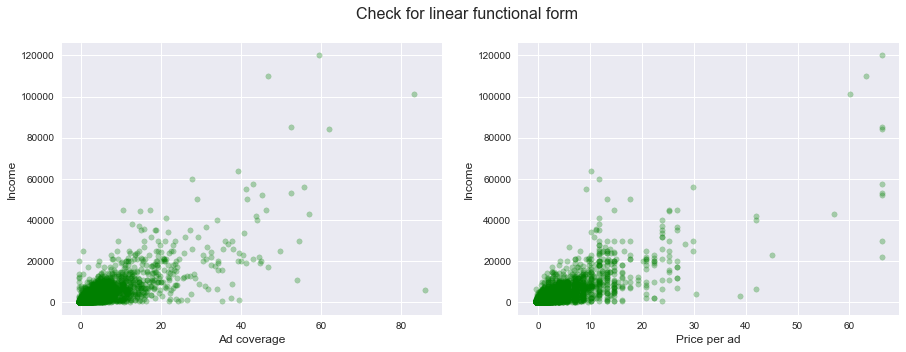

In [27]:
print('Pearson’s correlation coefficients:')
print(X_train_numeric[['Ad coverage','Price per ad']].corrwith(y_train['Income']))

fig = plt.figure(figsize = (15,5))
plt.style.use('seaborn')
fig.suptitle('Check for linear functional form', fontsize=16)

spec = fig.add_gridspec(1, 2)
f_ax1 = fig.add_subplot(spec[0, 0])
f_ax2 = fig.add_subplot(spec[0, 1])

f_ax1.scatter(x = X_train_numeric['Ad coverage'], y = y_train['Income'], c="g", alpha=0.3, s = 30)
f_ax2.scatter(x = X_train_numeric['Price per ad'], y = y_train['Income'], c="g", alpha=0.3, s = 30)

f_ax1.set_xlabel('Ad coverage', fontsize = 12)
f_ax2.set_xlabel('Price per ad', fontsize = 12)

f_ax1.set_ylabel('Income', fontsize = 12)
f_ax2.set_ylabel('Income', fontsize = 12)

plt.show()

Although, linear relationships are not obvious and it's difficult to determine them visually, values of Pearson’s correlation coefficient are significant enough to confirm the first assumption.

**2. Residual errors should be independent, identically distributed random variables**

Even though it might not be easy to detect independence of residual errors, one of the ways is to plot residual errors versus predicted values. Ideally, residual errors should be equally and randomly spaced around the horizontal axis.

Unfortunately, on the plot below it is clear that residual errors are far from perfect and have a cone-shaped pattern.


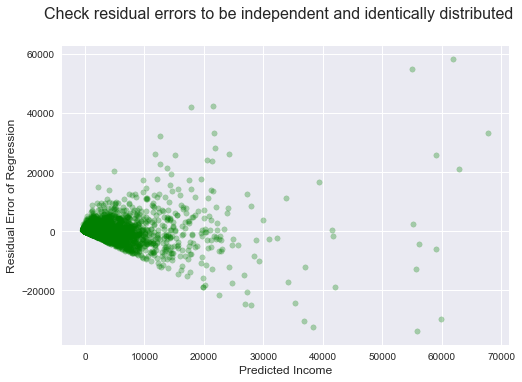

In [28]:
from statsmodels.regression import linear_model

olsr_results = linear_model.OLS(y_train, X_train_numeric).fit()
olsr_predictions = olsr_results.get_prediction(X_train_numeric)

prediction_summary_frame = olsr_predictions.summary_frame()

y_pred = prediction_summary_frame['mean']
resid = y_train['Income'] - y_pred

plt.suptitle('Check residual errors to be independent and identically distributed', fontsize = 16)
plt.xlabel('Predicted Income', fontsize=12)
plt.ylabel('Residual Error of Regression', fontsize=12)
plt.scatter(y_pred, resid, c="g", alpha=0.3, s = 30)

plt.show()

**3. Residual errors should be homoscedastic**

*I skip the normality check because it's not strictly required.*

I check homoscedasticity of the residuals using Breusch-Pagan test. It establishes whether the variance of the residual errors is constant or not. 

In [29]:
from statsmodels.stats.diagnostic import het_breuschpagan

resid = resid.values.reshape(19442,1)
bp_test = het_breuschpagan(resid, X_train_numeric)

labels = ['Lagrange Multiplier Statistic', 'LM-Test p-value', 'F-Statistic', 'F-Test p-value']
print(dict(zip(labels, bp_test)))

{'Lagrange Multiplier Statistic': 4787.924990063729, 'LM-Test p-value': 0.0, 'F-Statistic': 3175.8149778722773, 'F-Test p-value': 0.0}


Heteroskedasticity is indicated if p-value is below 0.05, and based on this test, I reject the null hypothesis of the F-test that the residuals errors are homoscedastic and accept the alternative hypothesis that residual errors are heteroscedastic.

So, the training set failed to fit linear regression model assumptions. There are several ways to deal with such situation and various models to apply.

## 2.4 FEATURE  SELECTION

Next step is dimensionality reduction. 73 columns might be too much and result in overfitting. To avoid negative effect of information overload, I use Random forrest. It determines the importance of each variable in decreasing impurity and select the most valuable ones.

In [39]:
y_train = y_train.values.ravel()

rf = RandomForestRegressor().fit(X_train_prep, y_train)

feature_importances = pd.DataFrame(rf.feature_importances_, index =X_train_prep.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances = feature_importances[feature_importances.importance > 0.005].index.tolist()

X_train_sel = X_train_prep.loc[:,feature_importances]
X_test_sel = X_test_prep.loc[:,feature_importances]

It's interesting to see what featues were eliminated due to their low impact to the model.

Wow! It seems that almost all topics and week day/month selection are not so significat in prediction of advertisement result. What plays the determing role is combination of price and ad coverage. 

In [45]:
removed_features = [x for x in X_train_prep.columns.tolist() if x not in feature_importances]

print('Features that were removed:')
print(removed_features)

print()

print('Selected features:')
print(feature_importances)

Features that were removed:
['Auto', 'Business', 'Body-positivity', 'Beauty', 'Home', 'Another topic', 'Animals', 'Healthy lifestyle', 'Health', 'Languages', 'Books', 'LGBT', 'Lifestyle', 'Mothers', 'Fashion', 'Motivation', 'Music', 'Science', 'No topic', 'Photo Retouching', 'Education', 'Relationships', 'Right nutrition', 'Diets', 'Ecology', 'Productivity', 'Lawyer', 'Psychology', 'Travelling', 'Design and decor', 'Food', 'Handicraft', 'SMM', 'Garden', 'Self-development', 'Sex', 'Family', 'Social topics', 'Sport', 'Dancing', 'Art', 'Feminism', 'Movies', 'Esotericism', 'Humor', 'Designer', 'Renovation', 'PR', 'Shopping and style', 'Format_Пост + сторис', 'Format_Сторис', 'Format_Фото-пост', 'Month_2', 'Month_3', 'Month_4', 'Month_5', 'Month_6', 'Month_7', 'Month_8', 'Month_9', 'Month_12', 'Week day_1', 'Week day_2', 'Week day_3', 'Week day_4', 'Week day_5', 'Week day_6']

Selected features:
['Price per ad', 'Ad coverage', 'Month_10', 'Lifehacks', 'Life abroad', 'Month_11']


## 2.5 REGRESSION  MODELS  &  APPLICATION

I tried 3 modes that are not limited with assumptions to the data: polynomial regression, decission tree and random forrest. To evaluate each model I apply 2 metrics: RMSE (root mean squared error) and R-squared:

- RMSE shows the absolute value of how much predictions deviate from the actual value. This metric should be used to compare models against each other, because by itself it doesn't give valuable information;

- R-squared shows the percentage of the variance in the dependent variable that the independent variables explain collectively. This metric is used to evaluate model's goodness-of-fit.

**Polynomial regression**

The quadretic model with L2 - regularization term produces sufficient results and tackles the problem of overfitting. I have trained models with various hyperparameter alpha, the best result was achieved with alpha equals 1000. 

In [41]:
polynomial_features= PolynomialFeatures(degree=2)
X_train_poly = polynomial_features.fit_transform(X_train_sel)
X_test_poly = polynomial_features.fit_transform(X_test_sel)

In [42]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

ridge_test_scores = []

for a in alphas:
    model = Ridge(alpha = a)
    model.fit(X_train_poly, y_train)
    score = model.score(X_test_poly, y_test)
    ridge_test_scores.append(score)
    if score >= max(ridge_test_scores):
        model_prediction = model.predict(X_test_poly)
    

best_alpha = max(ridge_test_scores)
best_alpha_index = ridge_test_scores.index(best_alpha)

print('Best r^2 - score of {:.2f} was achieved with alpha equals to {} .'.format(best_alpha, alphas[best_alpha_index]))

print('Mean squared error of this model is {:.2f}.'.format(math.sqrt(mean_squared_error(y_test, model_prediction))))

Best r^2 - score of 0.67 was achieved with alpha equals to 1000 .
Mean squared error of this model is 1655.43.


**Decission Tree**

This models is intuitive and easy to explain, can handle nonlinear data and requires little data preparation. The hyperparameter to choose is maximum depth of the tree: the more complex the tree, the better model fits data. Nevertheless,  we should stop at some depth to avoid overfitting. I'he trained DT-model with depth from 1 to 20, best result was achieved with max depth equals 5.

In [46]:
depth = np.arange(1,20)

tree_scores = []

for i in depth:
    tree = DecisionTreeRegressor(max_depth = i, random_state = 20)
    tree.fit(X_train, y_train)
    score = tree.score(X_test, y_test)
    tree_scores.append(score)
    if score >= max(tree_scores):
        tree_prediction = tree.predict(X_test)
    

best_tree = max(tree_scores)
best_tree_index = tree_scores.index(best_tree)

print('Best r^2 - score of {:.2f} was achieved with {}-estimators.'.format(best_tree, depth[best_tree_index]))
print('Mean squared error of this model is {:.2f}.'.format(math.sqrt(mean_squared_error(y_test, tree_prediction))))

Best r^2 - score of 0.70 was achieved with 5-estimators.
Mean squared error of this model is 1598.39.


**Random forrest**

Random forrest is an ensemble method  that uses n-number of decision trees to train them on n-number of data sebsets. As I have already found out that the best maximum depth of a single decision tree is 5, the only hyperparameter to chose is amount of estimators. I've trained the model with 100, 200, 300, 400 and 500 estimators, and the best result was achieved with 500 estimators.

In [43]:
n_estimators = [100,200,300,400,500]
scores_test = []

for i in n_estimators:
    regressor = RandomForestRegressor(n_estimators = i, max_depth = 5, random_state = 20)
    regressor.fit(X_train_sel, y_train)
    score = regressor.score(X_test_sel, y_test)
    scores_test.append(score)
    if score >= max(scores_test):
        regressor_prediction = regressor.predict(X_test_sel)
  

best_estimator = max(scores_test)
best_estimator_index = scores_test.index(best_estimator)

print('Best r^2 - score of {:.2f} was achieved with {}-estimators.'.format(best_estimator, n_estimators[best_estimator_index]))
print('Mean squared error of this model is {:.2f}.'.format(math.sqrt(mean_squared_error(y_test, regressor_prediction))))



Best r^2 - score of 0.72 was achieved with 500-estimators.
Mean squared error of this model is 1539.95.


**Final Model & Function**

As you can see, the model that fits best to the data is Random Forrest Regressor with 500 trees and maximum depth of 5 each.

In [50]:
MODEL = RandomForestRegressor(n_estimators = 500, max_depth = 5, random_state = 20) 
MODEL.fit(X_train_sel, y_train)



def predict_subscribers(date = '01.01.2021', price = 100, ad_coverage = 1000, *topics):
    df  = pd.DataFrame(0, index=range(1), columns = X_test_sel.columns)
    #numerical columns
    df['Ad coverage'] = ad_coverage
    df['Price per ad'] = price
    
    df[['Price per ad','Ad coverage']] = rs.transform(df[['Price per ad','Ad coverage']])
    
    #date columns
    datetime = pd.to_datetime(date, format = '%d.%m.%Y')
    month = datetime.month
    week_day = datetime.weekday()
    str_1 = 'Week day_'+ str(week_day)
    str_2 = 'Month_' + str(month)
    df[df.filter(like = str_1).columns] = 1
    df[df.filter(like = str_2).columns] = 1
    
    #topics' columns
    for i in topics:
        df[df.filter(like = i).columns] = 1
    
    prediction = MODEL.predict(df)
    
    return np.round(prediction) 
    
    


In [52]:
predict_subscribers('01.06.2021', 2500 , 3600, 'Travelling')    

array([365.])

For instance, if I take an advertisement in the blog @chokonatta with following parameters:

- date = 01.06.2021 - tuesday

- price = 2500;

- ad_coverage (based on current statistics of blogger) = 3600;

- topics = Travelling;

approximate amount of new subscribers is 365.